In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import statsmodels.api as sm

from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate, TimeSeriesSplit

import warnings

SEED = 42
warnings.filterwarnings('ignore')

### Первоначальный Preprocessing 
Осуществим первоначальный анализ временного ряда:
- Проверим на наличие пропусков и заполним их при необходимости 
- Визуализируем ряд (исходный ряд, декомпозиция на тренд, сезонность)
- Взглянем на стационарность и примем решение о стабилизации дисперсии или сглаживании ряда

In [2]:
# Загрузим ряд 
ts_data = pd.read_csv('data\performance_data.csv')
ts_data

,counter_timestamp,counter_data
0,2022-02-21 16:15:00,10408.421667
1,2022-02-21 16:30:00,10493.064667
2,2022-02-21 16:45:00,10370.143667
3,2022-02-21 17:00:00,11169.873000
4,2022-02-21 17:15:00,11111.825000
...,...,...
2801,2022-03-22 23:00:00,NaN
2802,2022-03-22 23:15:00,1993.071000
2803,2022-03-22 23:30:00,1573.885667
2804,2022-03-22 23:45:00,1005.688000


Значений в ряде не так много, частота 15-ти минутные тики 

In [3]:
# Взглянем на пропущенные значения
ts_data.isna().sum()

counter_timestamp     0
counter_data         28
dtype: int64

In [4]:
# Также сразу приведем время к TimeStamp и установим как индекс  
ts_data['counter_timestamp'] = pd.to_datetime(ts_data['counter_timestamp'])
ts_data = ts_data.set_index('counter_timestamp')

# Добавим частоту в индекс, у нас частота наблюдений каждые 15 мин
ts_data = ts_data.asfreq('15min')

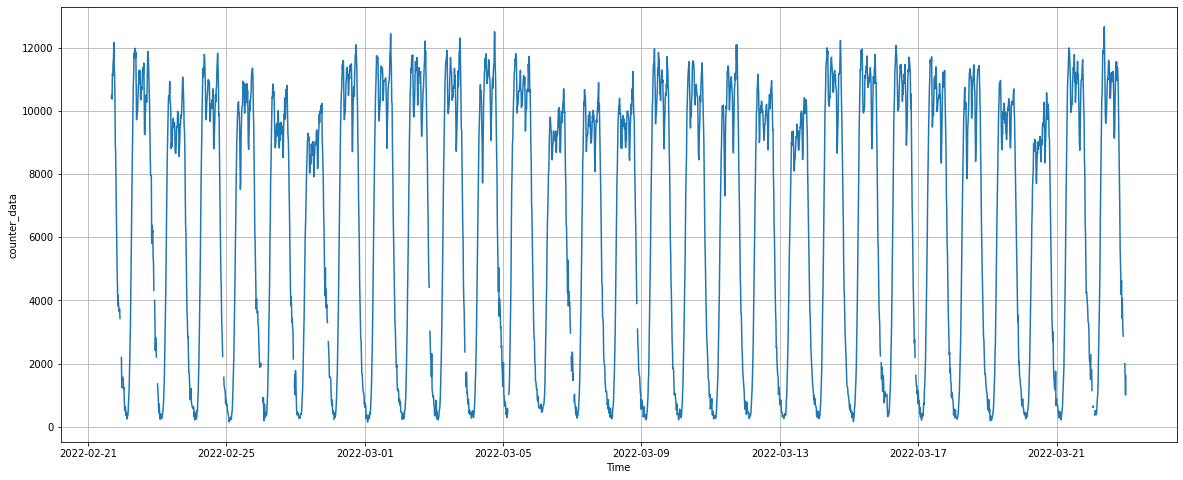

In [5]:
# Визуализируем ряд 
def plot_sereis(series, x_name, y_name):
    plt.figure(figsize=(20,8))
    plt.plot(series)
    plt.grid(True)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    
plot_sereis(ts_data['counter_data'], x_name='Time', y_name='counter_data')

Отчётливо видим пропуски данных. **Однако мы можем очень легко интерполировать данные значения**

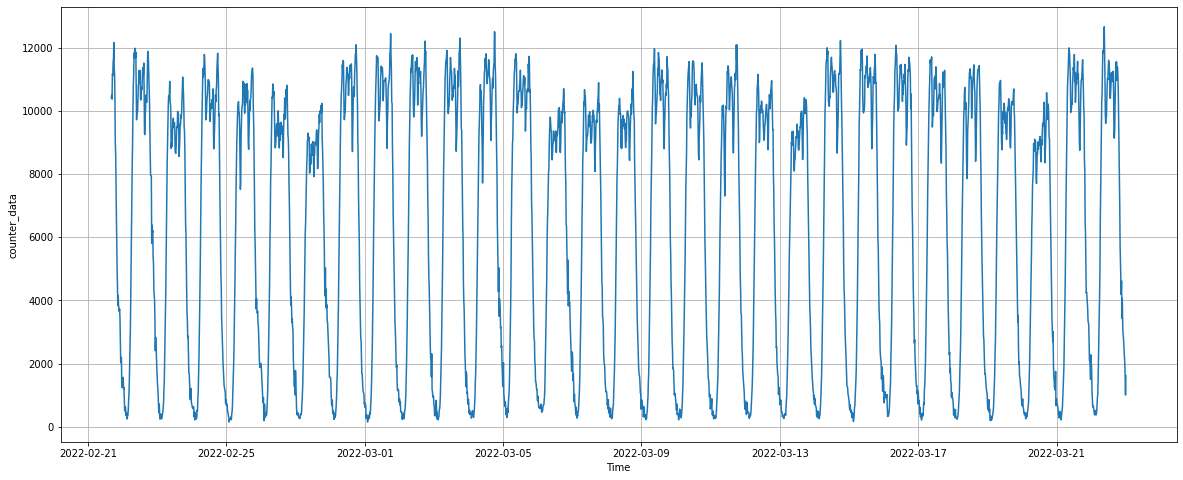

In [6]:
# Интерполируем неизвестные значения 
ts_data = ts_data.interpolate()

# Снова визуализируем
plot_sereis(ts_data['counter_data'].interpolate(), x_name='Time', y_name='counter_data')

Пропуски заполнены и зависимость ряда сохранена

In [7]:
# Взглянем на статистики по ряду 
ts_data.describe()

,counter_data
count,2816.000000
mean,6448.116829
std,4256.182841
min,150.192333
25%,1605.458583
50%,8405.824667
75%,10297.086750
max,12663.087667


Сглаживать ряд и делать дальнейшую предобработку ряда особо не стоит. Дисперсия и уровень/тренд стабильны

Ряд колеблется вокруг своего среднего (6462.58) с дисперсией (4254.96)

Можно проверить на стационарность при помощи критерия Дикки-Фуллера (как rule-of-thumb)
- `H0: ряд нестационарный`

In [8]:
def check_stationarity(series):
    dikki_fuller_values = sm.tsa.stattools.adfuller(series.values)
    print('Diki-Fuller p-value: %.3f' %dikki_fuller_values[1])

check_stationarity(ts_data['counter_data'])

Diki-Fuller p-value: 0.000


`p-value` очень мал, следовательно, гипотеза о нестационарности ряда отвергается

Также интересно взглянуть на декомпозицию ряда

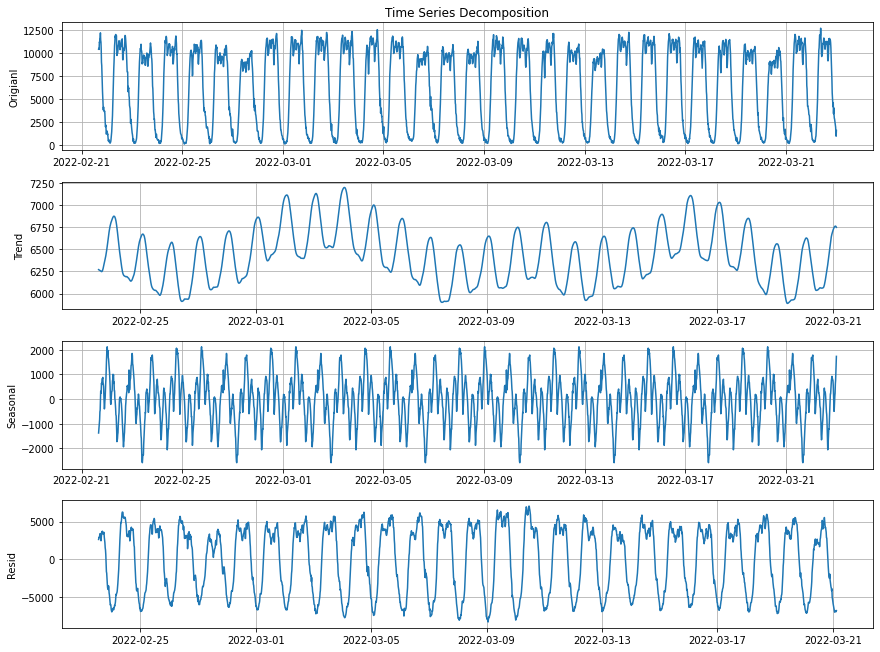

In [9]:
# Определим функцию для декомпозиции ВР
def plot_decomposition(series, figsize = (12, 9), grid=True):
    ts_compnts = sm.tsa.seasonal_decompose(series, period=360)
    titles = ['Origianl', 'Trend', 'Seasonal', 'Resid']

    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=figsize)
    plt.tight_layout()
    ax[0].set_title('Time Series Decomposition')
    
    ax[0].plot(series)
    ax[1].plot(ts_compnts.trend)
    ax[2].plot(ts_compnts.seasonal)
    ax[3].plot(ts_compnts.resid)
    
    for indx, title in enumerate(titles):
        ax[indx].set_ylabel(title)
        ax[indx].grid(True)
        
plot_decomposition(ts_data['counter_data'])

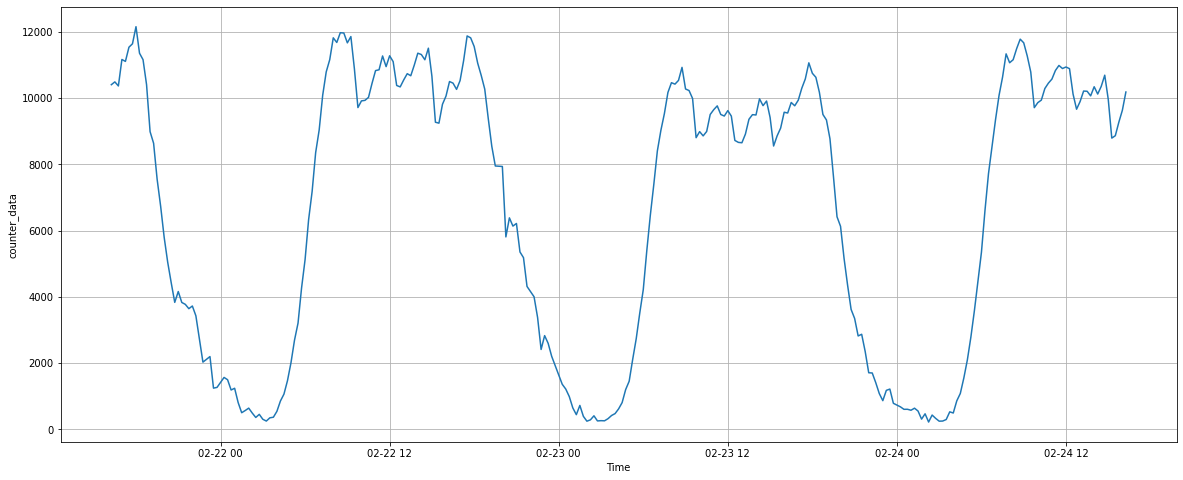

In [10]:
# Взглянем на ряд в разрезе 4 дней
plot_sereis(ts_data.loc['2022-02-21 16:15:00': '2022-02-24 16:15:00']['counter_data'], x_name='Time', y_name='counter_data')

Можно заметить что имеется сезонность
- Минимальные значения всегда приходятся на промежуток 2-3ч ночи
- Максимальные значения на каждые 12ч дня

Это можно использовать при создании признаков на основе времени

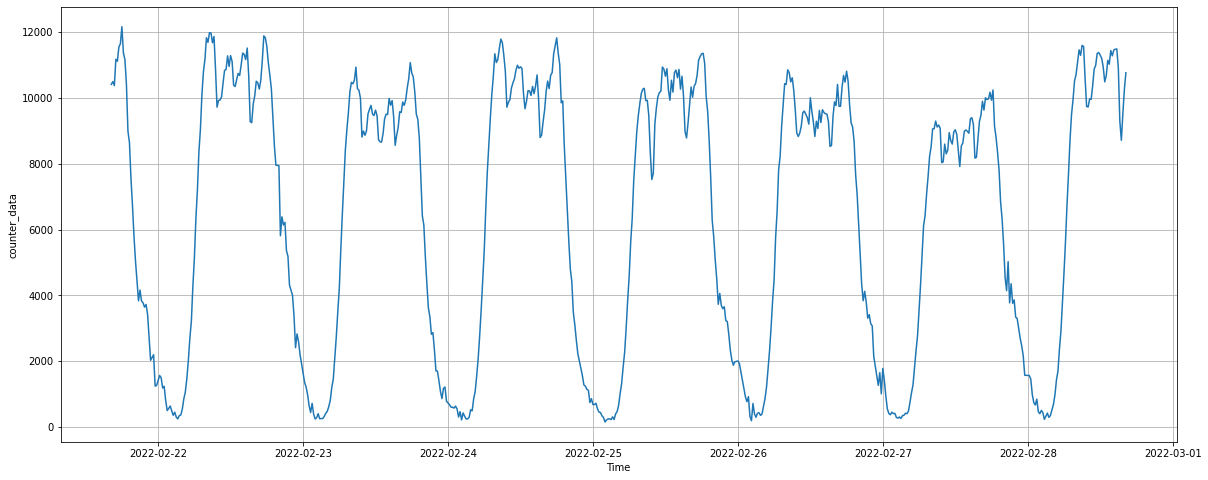

In [11]:
plot_sereis(ts_data.loc['2022-02-21 16:15:00': '2022-02-28 16:15:00']['counter_data'], x_name='Time', y_name='counter_data')

Отчетливо виден тренд и сезонность данного ряда

### Выбор Метрик
Оценку качества прогноза можно делать по следующим метрикам. Мы выберем интерпретируемые метрики:
- `RMSE`
- `MAPE`

In [12]:
# Определим метрику MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Определим RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Поиск Аномальных Значений 
Поиск аномалий во временном ряде будем осуществлять при помщи 95% доверительного интервала, используя правило 2-х сигм

Для исходного временного ряда необходимо определить окно сглаживания

Размер окна будет определять размер доверительных границ ряда (т.е. мы строим скользящее среднее для n-точек ряда)

In [13]:
# Функция для отрисовки доверительных границ и поиска аномалий 
def show_anomalies(series, win_size, metric, figsize, sigma_val=1.96,
                   plot_intervals=True, plot_anomalies=True, plot_rolling_mean_trend=True):
    
    # Сглаживаем в зависимости от размера окна 
    rolling_mean = series.rolling(window=win_size).mean()
    
    plt.figure(figsize=figsize)
    plt.title(f"Скользящее Среднее для ВР\n Размер Окна = {win_size}")
    if plot_rolling_mean_trend:
        plt.plot(rolling_mean, "g", label="Скользящее Среднее (Тренд)")
    
    # Рисуем доверительные интервалы
    if plot_intervals:
        error = metric(series[win_size:], rolling_mean[win_size:])
        std = np.std(series[win_size:] - rolling_mean[win_size:])
        lower_bond = rolling_mean - (error + sigma_val * std)
        upper_bond = rolling_mean + (error + sigma_val * std)
        plt.plot(upper_bond, "r--", label="Верхняя Граница / Нижняя Bond")
        plt.plot(lower_bond, "r--")
        
        # Находим аномалии 
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[win_size:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

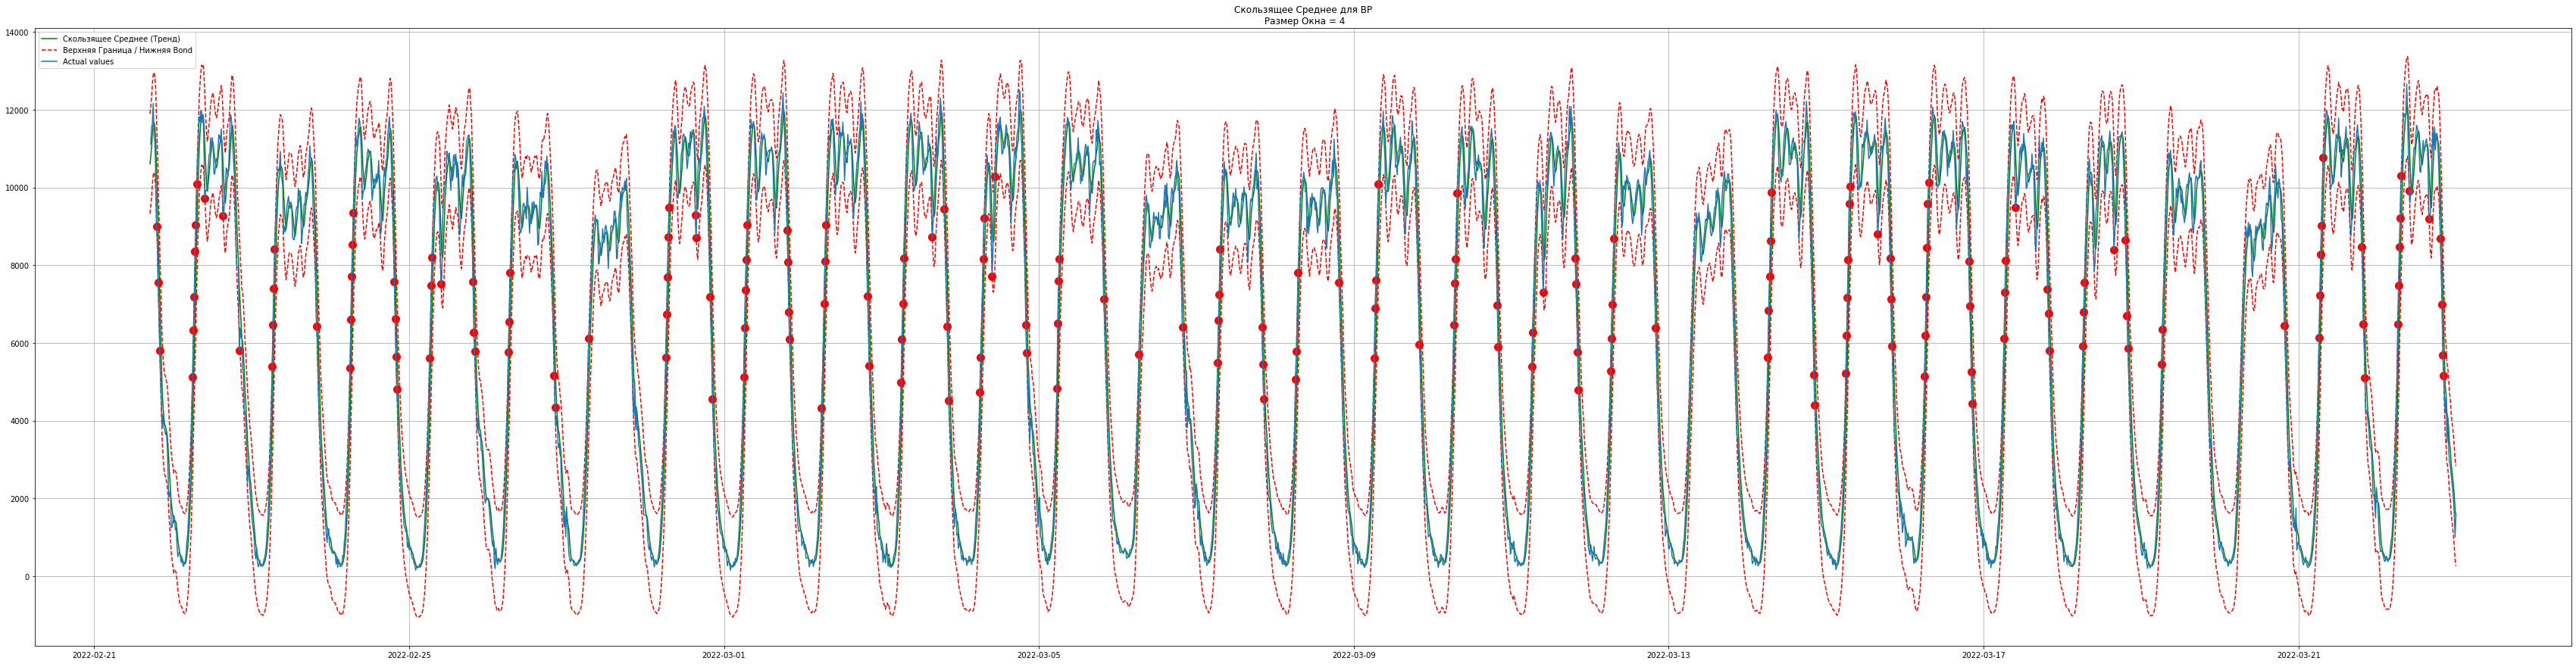

In [14]:
# Сгладим по часу (~4 точки) 
show_anomalies(series=ts_data,
               win_size=4,
               metric=mean_absolute_percentage_error,
               sigma_val=1.96,
               plot_intervals=True,
               plot_anomalies=True,
               plot_rolling_mean_trend=True,
               figsize=(60, 15))

Для более наглядной визуализации лучше сохранить картинку

Видно, что при сглаживании ряда по 1 часу мы получаем довольно немало выбросов/аномалий

### Генерация Признаков
Произведем извлечение основных признаков из временного ряда 

In [15]:
# Признаки времени 
def get_time_features(series):
    features_df = series.copy() # чтобы не изменять исходный series
    
    # Признаки времени
    features_df['minute'] = features_df.index.minute
    features_df['day_of_month'] = features_df.index.day
    features_df['day_name'] = features_df.index.day_name()

    # Выходной и Праздники (Бинарные)
    features_df['is_weekend'] = features_df.index.weekday.isin([5,6])*1 # Умножаем на 1 чтобы получить 0/1 вместо True/False
    
    # Бинарные признаки на 03:00:00/12:00:00
    features_df['is_hour_03_00'] = (features_df.reset_index()['counter_timestamp'].apply(lambda x: x.time() == datetime.time(3, 0))*1).values
    features_df['is_hour_12_00'] = (features_df.reset_index()['counter_timestamp'].apply(lambda x: x.time() == datetime.time(12, 0))*1).values
    
    # Кодирование Категорий
    ohe_columns = ['day_name']
    features_df = pd.get_dummies(features_df, columns=ohe_columns, drop_first=True)
    
    return features_df 

In [16]:
# Лаги ряда 
def get_lags(df, target_col_name, lag_start=1, lag_end=48, drop_target_col=True):
    features_df = df.copy()
    for i in range(lag_start, lag_end+1):
        features_df[f"lag_{i}"] = features_df[target_col_name].shift(i)
    features_df = features_df.dropna(axis='rows')
    
    if drop_target_col:
        features_df = features_df.drop(columns=target_col_name)
    return features_df

# График автокорреляционной функции 
def plot_acf_pacf(series, lags=30, figsize=(12, 7)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(series.values, lags=lags, ax=ax)
    plt.grid(True)
    
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(series.values, lags=lags, ax=ax)
    plt.grid(True)

Для определения необходимого числа лагов используем график автокорреляционной функции

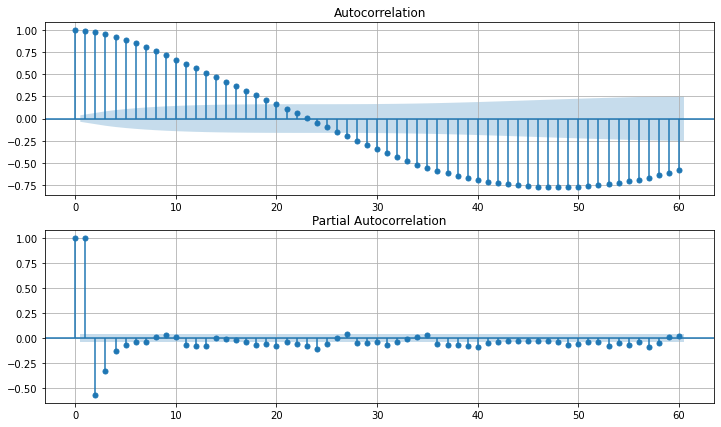

In [17]:
# Рассмотрим первые 60 лагов 
plot_acf_pacf(ts_data, lags=60)

График ACF показывает, что имеется сезонность через каждые 50 наблюдений (текущее значение сильно коррелирует с лагами 50/100...)

Больше 50 лагов можно не использовать

In [18]:
# Признаки на скользящем окне 
def get_rolling_window_features(series, target_col_name, window_size=[12, 24], statistics=['avg'], drop_target_col=False):
    res_df = pd.DataFrame()
    res_df[target_col_name] = series[target_col_name]
    for statistic in statistics:
        for size in window_size:
            if statistic == 'avg':
                res_df[f'rolling_{statistic}_{size}'] = series[target_col_name].rolling(size).mean()
            elif statistic == 'min':
                res_df[f'rolling_{statistic}_{size}'] = series[target_col_name].rolling(size).min()
            elif statistic == 'max':
                res_df[f'rolling_{statistic}_{size}'] = series[target_col_name].rolling(size).max()
            elif statistic == 'sum':
                res_df[f'rolling_{statistic}_{size}'] = series[target_col_name].rolling(size).sum()
            elif statistic == 'std':
                res_df[f'rolling_{statistic}_{size}'] = series[target_col_name].rolling(size).std()
    res_df = res_df.dropna()
    if drop_target_col:
        res_df = res_df.drop(columns=target_col_name)
    return res_df

In [19]:
# Формируем признаки
time_features = get_time_features(ts_data)
lag_features = get_lags(ts_data, target_col_name='counter_data', lag_start=1, lag_end=50, drop_target_col=True)
rolling_win_feat = get_rolling_window_features(ts_data, target_col_name='counter_data', 
                                               window_size=[48, 96], statistics=['avg', 'std', 'sum'], 
                                               drop_target_col=False).drop(columns='counter_data')

features_df = pd.concat([time_features, lag_features, rolling_win_feat], axis='columns')

features_df.fillna(0, inplace=True) # !

### Разделение на Train/Test
По условию задания необходимо сделать прогноз на следующие сутки и оценить качество модели 

Отрежем последний день и добавим его в `test` (это послдение 4 точки)

In [20]:
# Данные для train/test
train_data = features_df.iloc[:-96]
inference_data = features_df.iloc[-96:]

# Матрица признаков и таргет 
X = train_data.drop(columns='counter_data')
y = train_data['counter_data']

### Модель
В качестве модели выбирем градиентный бустинг `CatBoost`

In [21]:
# Определяем основной разрез метрик
scoring = {
    'mape': make_scorer(mean_absolute_percentage_error),
    'rmse': make_scorer(root_mean_squared_error)
    }

# Определяем модель c начальными параметрами
model = CatBoostRegressor(iterations=100,
                          learning_rate=0.48,
                          depth=6,
                          l2_leaf_reg=0.55,
                          logging_level='Silent',
                          cat_features=['minute'],
                          loss_function='RMSE',
                          bootstrap_type='Bayesian',
                          random_strength=1.5,
                          random_seed=SEED, 
                          early_stopping_rounds=100,
                          task_type='GPU')

# Кросс-Валидируемся
cv_results = cross_validate(model, X=X, y=y,
                            cv=TimeSeriesSplit(n_splits=5),
                            scoring=scoring,
                            error_score='raise')

# Результаты CV 
print('CV Results: ')
cv_df = pd.DataFrame(cv_results)
cv_df[cv_df.columns[2:]].mean()

CV Results: 


test_mape     19.384420
test_rmse    556.773945
dtype: float64

Получили относительно неплохое качество на кросс-валидации для 5 фолдов

В среднем прогноз ошибается на 20% или примерно на 557 ед целевого признака

Можно добавить еще признаки и улучшить качество прогноза, но для BaseLine очень даже неплохо

### Inference
Теперь обучим модель и оценим ошибку на тестовой выборке. Примерно должны получить ошибку близкую или ниже/чуть выше `CV-error`

In [22]:
# Test Data
X_test = inference_data.drop(columns='counter_data')
y_test = inference_data['counter_data']

# Фитим Модель 
model.fit(X, y)
model_preds = model.predict(X_test)

# Снова смотрим на метрики 
print('Test MAPE: ', mean_absolute_percentage_error(y_test, model_preds))
print('Test RMSE: ', root_mean_squared_error(y_test, model_preds))

Test MAPE:  9.011163092256595
Test RMSE:  379.7606835133732


Очень неплохо мы в среднем ошибаемся на 9% что эквивалентно 380 ед таргета

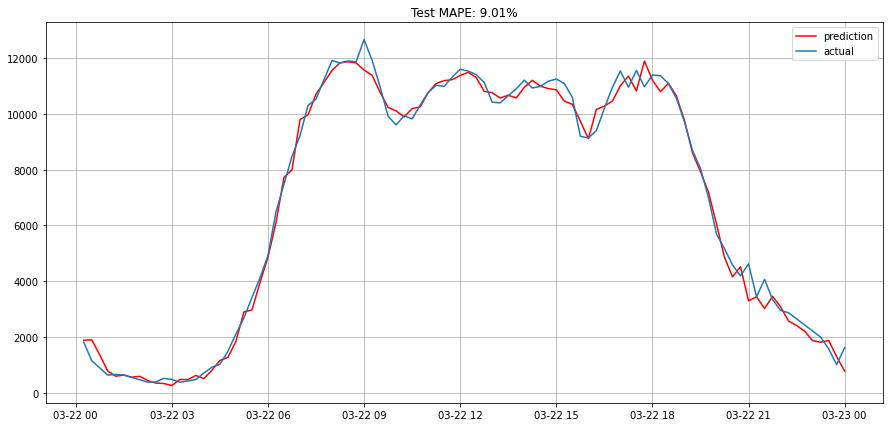

In [23]:
# Оформим прогноз в DataFrame
forecast_df = pd.DataFrame(y_test)
forecast_df['forecast'] = model_preds

# Визуализируем прогноз модели 
plt.figure(figsize=(15, 7))
plt.plot(forecast_df['forecast'], "r", label="prediction")
plt.plot(forecast_df['counter_data'], label="actual")
plt.title(f'Test MAPE: {round(mean_absolute_percentage_error(y_test, model_preds),2)}%')
plt.legend(loc="best")
plt.grid(True);

Очень даже неплохо, можно заметить, что модель слабо улавливает различные колебания среди дня.

Это можно исправить, добавив новые признаки. 

Однако основные зависимости очень хорошо "пойманы" и модель показывает очень даже неплохую способность к обобщению!

### Аномалии в Прогнозе

In [24]:
# Определим функцию для определения аномалий в прогнозе 
def show_anomalies_forecast(actual, pred, metric, figsize, sigma_val=1.96, 
                            plot_anomalies=True):
      
    plt.figure(figsize=figsize)
    plt.title('Прогноз Модели')
    plt.plot(pred, "g", label="Прогноз", linewidth=2.0)
    plt.plot(actual, label="Истинное Значение", linewidth=2.0)
    
    std = np.std(pred)
     
    lower = pred - (sigma_val * std)
    upper = pred + (sigma_val * std)
    
    plt.plot(lower, "r--", label="Верхняя/Нижняя Граница", alpha=0.5)
    plt.plot(upper, "r--", alpha=0.5)
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(actual))
        anomalies[y_test<lower] = y_test[y_test<lower]
        anomalies[y_test>upper] = y_test[y_test>upper]
        plt.plot(anomalies, "o", markersize=10, label = "Аномалии")
        
    error = metric(actual, pred)
    plt.title(f"Test Error {round(error,2)}%")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

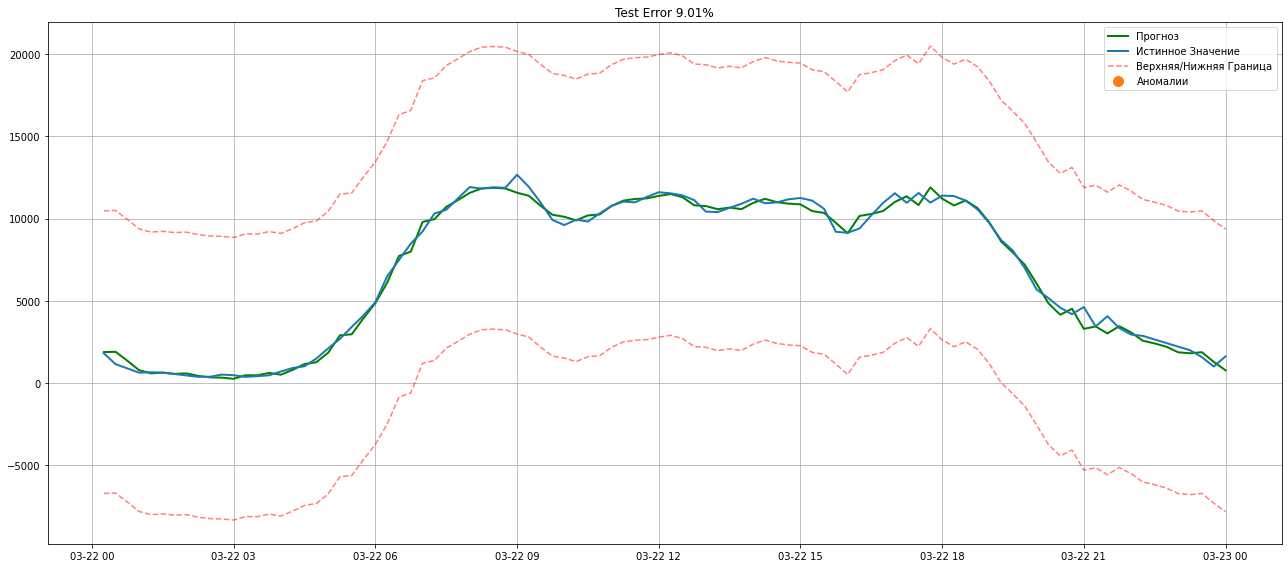

In [25]:
# Найдем аномалии, если имеются
show_anomalies_forecast(actual=forecast_df['counter_data'],
                        pred=forecast_df['forecast'],
                        metric=mean_absolute_percentage_error,
                        figsize=(18,8))

Аномалий в прогнозе не обнаружено 

### Merlion

In [98]:
from merlion.utils.time_series import TimeSeries
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.automl.autosarima import AutoSarima, AutoSarimaConfig
from merlion.models.forecast.sarima import Sarima

In [99]:
# Определим метрику MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Определим RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [101]:
# Data Preparation
ts_data = pd.read_csv('data\performance_data.csv')

# Также сразу приведем время к TimeStamp и установим как индекс  
ts_data['counter_timestamp'] = pd.to_datetime(ts_data['counter_timestamp'])
ts_data = ts_data.set_index('counter_timestamp')

# Добавим частоту в индекс
ts_data = ts_data.asfreq('min')

# Интерполируем неизвестные значения 
ts_data = ts_data.interpolate()

ts_data = ts_data['counter_data']
ts_data.head()

counter_timestamp
2022-02-21 16:15:00    10408.421667
2022-02-21 16:16:00    10414.064534
2022-02-21 16:17:00    10419.707400
2022-02-21 16:18:00    10425.350267
2022-02-21 16:19:00    10430.993134
Freq: T, Name: counter_data, dtype: float64

In [102]:
# Train/Test
period = 60*24*3 # 3 days - all data
df = ts_data[:period]
pred_horizon = 60*12 # test period

train_data = df[:-pred_horizon]
test_data = df[-pred_horizon:]

In [103]:
# Transform from Pandas to Merlion TimeSereis
train_data = TimeSeries.from_pd(train_data, freq='T')
test_data = TimeSeries.from_pd(test_data, freq='T')

In [94]:
config_1 = AutoSarimaConfig(auto_pqPQ=True,
                            auto_d=True,
                            auto_D=True,
                            auto_seasonality=True,
                            approximation=True,
                            maxiter=50)

model_1 = AutoSarima(config_1)

train_config = {
        "enforce_stationarity": True,
        "enforce_invertibility": False
}

# Model Training
train_pred, train_err = model_1.train(train_data,
                                      train_config=train_config)

In [95]:
# Model forecasting
forecast_1, stderr_1 = model_1.forecast(len(test_data))

# Model evaluation
mape = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast_1)
print(f"Full AutoSarima with approximation sMAPE is {mape:.4f}")

Full AutoSarima with approximation sMAPE is 135.5018


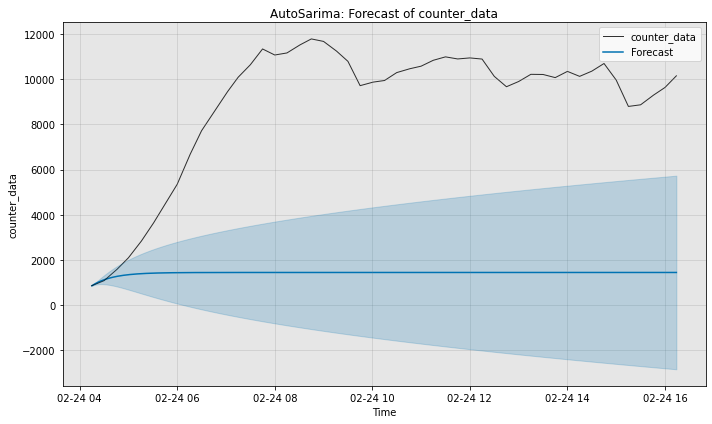

In [96]:
fig, ax = model_1.plot_forecast(time_series=test_data,
                                plot_forecast_uncertainty=True)
plt.show()

In [74]:
config_2 = AutoSarimaConfig(approximation=False, maxiter=15)
model_2  = AutoSarima(config_2)

train_config = {
        "enforce_stationarity": True,
        "enforce_invertibility": True
}

# Model training
train_pred, train_err = model_2.train(train_data, train_config=train_config)

In [75]:
# Model forecasting
forecast_2, stderr_2 = model_2.forecast(len(test_data))

# Model evaluation
smape2 = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast_2)
print(f"Full AutoSarima without approximation sMAPE is {smape2:.4f}")

Full AutoSarima without approximation sMAPE is 135.5018


In [76]:
config_3 = AutoSarimaConfig(auto_pqPQ=False,
                            order=(15, "auto", 5),
                            seasonal_order=(2, "auto", 1, "auto"),
                            maxiter=10)

model_3  = AutoSarima(config_3)

# Model training
train_pred, train_err = model_3.train(train_data,
                                      train_config=train_config)

In [78]:
forecast_3, stderr_3 = model_3.forecast(len(test_data))

# Model evaluation
smape3 = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast_3)
print(f"Partial AutoSarima without approximation sMAPE is {smape3:.4f}")

Partial AutoSarima without approximation sMAPE is 148.6947


In [80]:
config_4 = AutoSarimaConfig(approximation=True, maxiter=5)
model_4  = AutoSarima(config_4)

# Model training
train_pred, train_err = model_4.train(train_data,
                                      train_config={"enforce_stationarity": False,"enforce_invertibility": False})

In [81]:
# Model forecasting
forecast_4, stderr_4 = model_4.forecast(len(test_data))

# Model evaluation
smape4 = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast_4)
print(f"AutoSarima without enforcing stationarity and invertibility sMAPE is {smape4:.4f}")

AutoSarima without enforcing stationarity and invertibility sMAPE is 135.5018


In [67]:
from merlion.models.forecast.trees import LGBMForecaster, LGBMForecasterConfig

# set model configuration
lgbm_config = LGBMForecasterConfig(n_estimators=200,
                                   max_depth=8,
                                   maxlags = 25,
                                   max_forecast_steps=len(test_data))
# initialize model
lgbm = LGBMForecaster(lgbm_config)

# fit model
lgbm.train(train_data)

# forecast
lgbm_fc = lgbm.forecast(test_data.time_stamps)

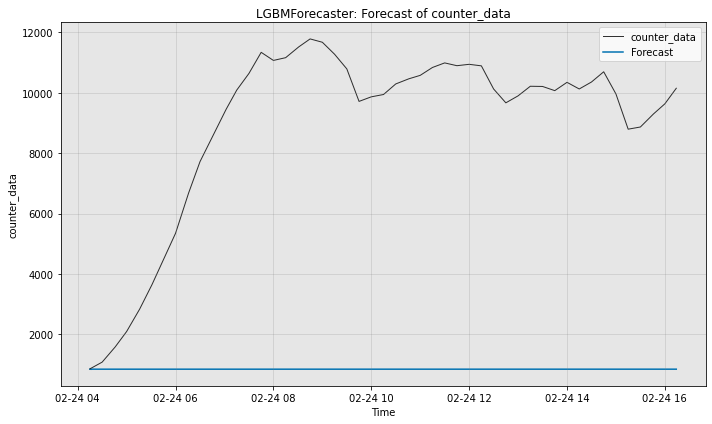

In [68]:
fig, ax = lgbm.plot_forecast(time_series=test_data)
plt.show()

In [95]:
period = 60*24*3 # 3 days - all data
df = ts_data[:period]
pred_horizon = 60*12 # test period

train_data = df[:-pred_horizon]
test_data = df[-pred_horizon:]

In [98]:
model = auto_arima(train_data,
                   trace=True,
                   error_action="ignore",
                   suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.71 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=25846.042, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=25848.042, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=25848.042, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=25850.042, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=25848.041, Time=0.06 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 2.106 seconds


In [110]:
forecast = model.predict(n_periods=5000)

In [103]:
test_data

counter_timestamp
2022-02-24 04:15:00      859.166333
2022-02-24 04:16:00      874.009155
2022-02-24 04:17:00      888.851978
2022-02-24 04:18:00      903.694800
2022-02-24 04:19:00      918.537622
                           ...     
2022-02-24 16:10:00    10002.891556
2022-02-24 16:11:00    10039.726978
2022-02-24 16:12:00    10076.562400
2022-02-24 16:13:00    10113.397822
2022-02-24 16:14:00    10150.233245
Freq: T, Name: counter_data, Length: 720, dtype: float64

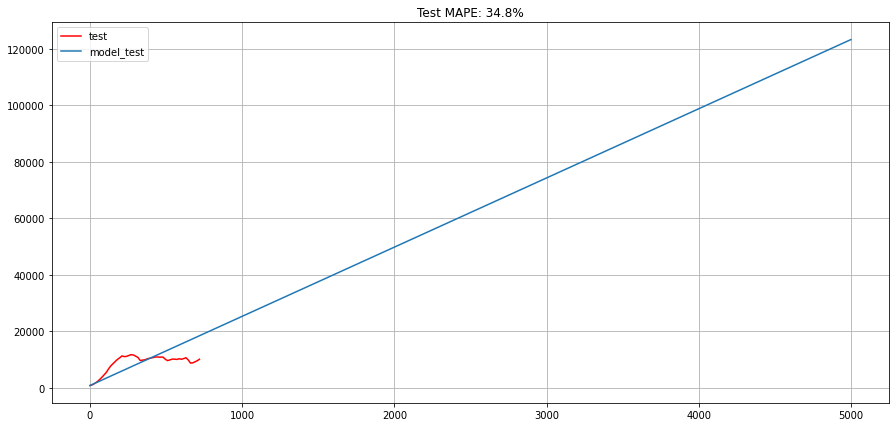

In [111]:
plt.figure(figsize=(15, 7))
plt.plot(test_data.values, "r", label="test")
plt.plot(forecast, label="model_test")
plt.title(f'Test MAPE: {round(mean_absolute_percentage_error(y_test, model_preds),2)}%')
plt.legend(loc="best")
plt.grid(True);

In [140]:
from pytsal.internal.entity import TimeSeries
from pytsal.internal.utils.helpers import get_freq

In [159]:
ts_data = pd.read_csv('data\performance_data.csv')

# Также сразу приведем время к TimeStamp и установим как индекс  
ts_data['counter_timestamp'] = pd.to_datetime(ts_data['counter_timestamp'])
ts_data = ts_data.set_index('counter_timestamp')

# Добавим частоту в индекс, у нас частота наблюдений каждые 15 мин
ts_data = ts_data.asfreq('min')

# Интерполируем неизвестные значения 
ts_data = ts_data.interpolate()

ts_data = ts_data['counter_data']

ts_data.head()

counter_timestamp
2022-02-21 16:15:00    10408.421667
2022-02-21 16:16:00    10414.064534
2022-02-21 16:17:00    10419.707400
2022-02-21 16:18:00    10425.350267
2022-02-21 16:19:00    10430.993134
Freq: T, Name: counter_data, dtype: float64

In [160]:
# Данные для train/test
ts_data = TimeSeries(ts=ts_data.iloc[:-96],
                        name='ts_data',
                        target='counter_data',
                        freq=ts_data.index.freqstr)

In [162]:
ts_data.freq

'T'

In [163]:
ts = load_airline()

In [164]:
ts.data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Date', length=144, freq='MS')

In [ ]:
def csv_loader(path: str, index: str = 'X', target: str = 'Y', freq=None) -> pd.Series:
    df = pd.read_csv(path)
    data = df[target].values
    _datetime_index = pd.to_datetime(df[index], infer_datetime_format=True)

    # Auto detect frequency
    seconds = (_datetime_index[1] - _datetime_index[0]).total_seconds()
    _freq = get_freq(seconds) if freq is None else freq

    # Create new pandas Series
    time_series = pd.Series(data=data, index=pd.DatetimeIndex(_datetime_index, freq=_freq), name=target)
    return time_series

INFO:pytsal.forecasting:Experiment started @ 2022-07-28 01:16:14.755061
INFO:pytsal.forecasting:Loading time series ...
INFO:pytsal.forecasting:Creating train test data
INFO:pytsal.forecasting:Initialize model tuning ...
INFO:pytsal.forecasting:Initializing comparison plot ...



--- Time series summary ---

name                                   ts_data
freq                                         T
target                            counter_data
type                                Univariate
phase                                     Full
series_length                            42130
start            2022-02-21T16:15:00.000000000
end              2022-03-22T22:24:00.000000000
dtype: object
"ts_data" dataset split with train size: 33704 test size: 8426
9 tunable params available for <class 'pytsal.internal.containers.models.forecasting.HoltWinter'>


ValueError: seasonal_periods has not been provided and index does not have a known freq. You must provide seasonal_periods

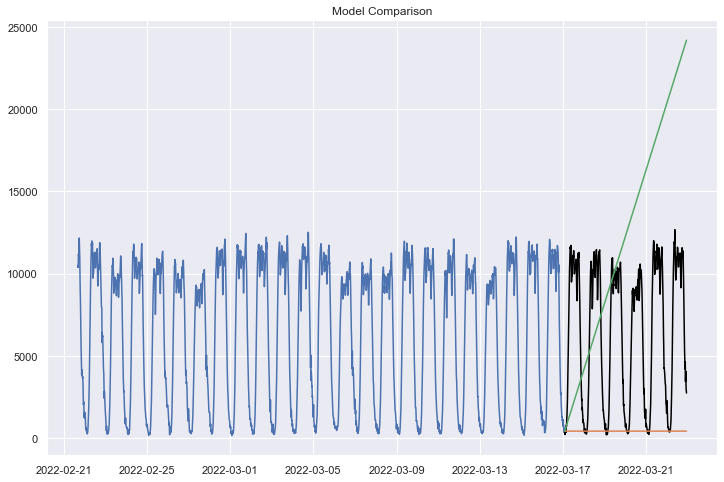

In [169]:
model = setup(ts_data, 'holtwinter', eda=False, validation=False, find_best_model=True, plot_model_comparison=True)

In [65]:
# # Данные для train/test
train_data = features_df.iloc[:-96]
inference_data = features_df.iloc[-96:]

# # # Матрица признаков и таргет 
# # X = train_data.drop(columns='counter_data')
# # y = train_data['counter_data']

INFO:pytsal.forecasting:Experiment started @ 2022-07-28 00:25:22.431286
INFO:pytsal.forecasting:Loading time series ...
INFO:pytsal.forecasting:Creating train test data
INFO:pytsal.forecasting:Initializing Visualizer ...
INFO:pytsal.visualization.eda:EDAVisualizer initialized



--- Time series summary ---

name                                   ts_data
freq                                       15T
target                            counter_data
type                                Univariate
phase                                     Full
series_length                             2720
start            2022-02-21T16:15:00.000000000
end              2022-03-22T00:00:00.000000000
dtype: object
"ts_data" dataset split with train size: 2176 test size: 544


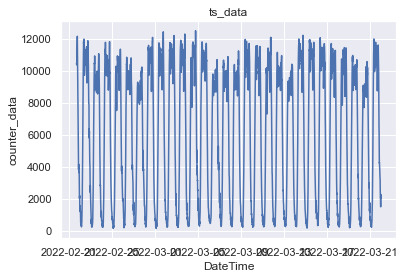

INFO:pytsal.visualization.eda:Constructed Time plot


ValueError: freq T not understood. Please report if you think this is in error.

In [101]:
model = setup(ts_data, 'holtwinter', eda=True, validation=True, find_best_model=True, plot_model_comparison=True)

In [ ]:
from pytsal.internal.entity import TimeSeries

In [ ]:
return TimeSeries(data, name, target, freq=data.index.freqstr)

In [29]:
from pytsal.dataset import load_airline

ts = load_airline()

In [64]:
train_data

INFO:pytsal.forecasting:Experiment started @ 2022-07-27 23:42:37.991254
INFO:pytsal.forecasting:Loading time series ...
INFO:pytsal.forecasting:Creating train test data
INFO:pytsal.forecasting:Initializing Visualizer ...
INFO:pytsal.visualization.eda:EDAVisualizer initialized



--- Time series summary ---

name             Monthly totals of international airline passen...
freq                                                            MS
target                                Number of airline passengers
type                                                    Univariate
phase                                                         Full
series_length                                                  144
start                                1949-01-01T00:00:00.000000000
end                                  1960-12-01T00:00:00.000000000
dtype: object
"Monthly totals of international airline passengers (1949 to 1960)" dataset split with train size: 116 test size: 28


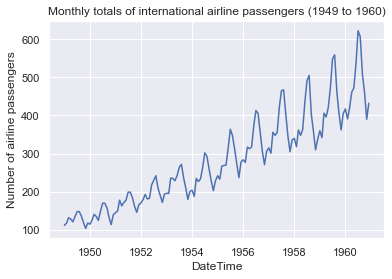

INFO:pytsal.visualization.eda:Constructed Time plot
INFO:pytsal.visualization.eda:Constructed decompose plot


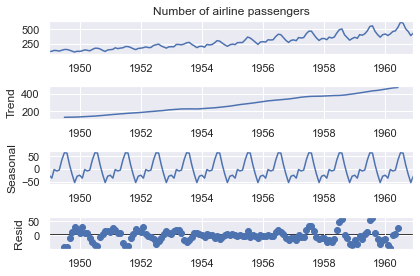

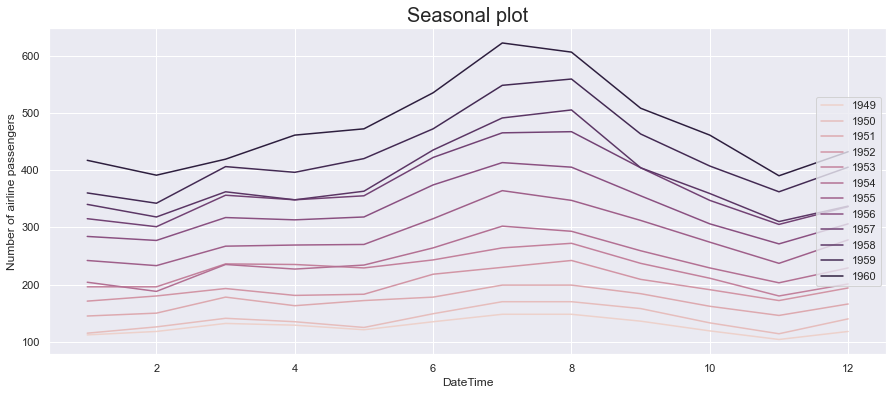

INFO:pytsal.visualization.eda:Constructed seasonal plot


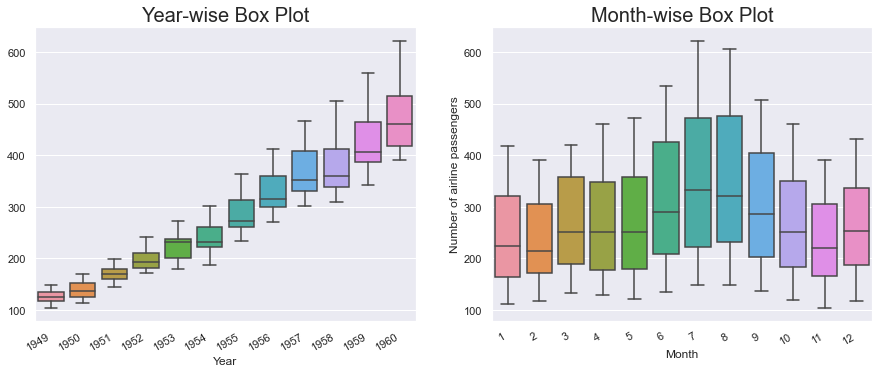

INFO:pytsal.visualization.eda:Constructed box plot


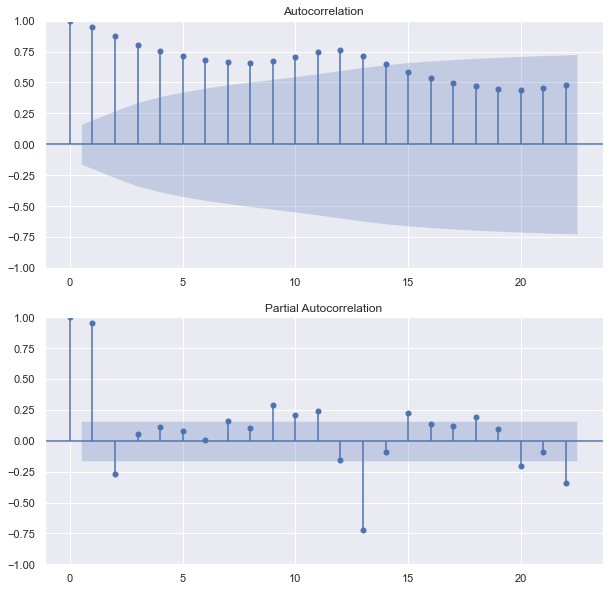

INFO:pytsal.visualization.eda:Constructed acf and pacf plot
INFO:pytsal.visualization.eda:Performing stationarity test
INFO:pytsal.visualization.eda:Test 1/2 ADF


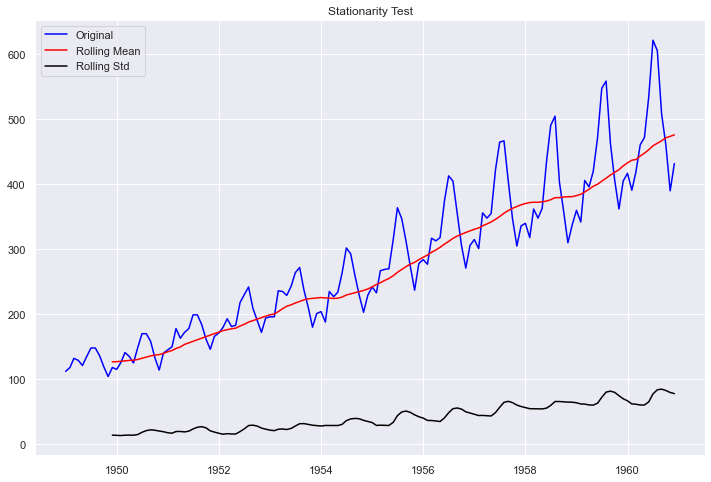

INFO:pytsal.visualization.eda:
Test 2/2 KPSS
INFO:pytsal.visualization.eda:Tests completed
INFO:pytsal.visualization.eda:Performed stationary tests
INFO:pytsal.visualization.eda:EDAVisualizer completed
INFO:pytsal.forecasting:Initialize model tuning ...
INFO:pytsal.forecasting:Initializing comparison plot ...


Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value 1%               -3.481682
Critical Value 5%               -2.884042
Critical Value 10%              -2.578770
dtype: float64
KPSS Statistic: 0.09614984853532418
p-value: 0.1
num lags: 4
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216

ADF: p-value = 0.9919. The series is likely non-stationary.
KPSS: The series is deterministic trend stationary
9 tunable params available for <class 'pytsal.internal.containers.models.forecasting.HoltWinter'>


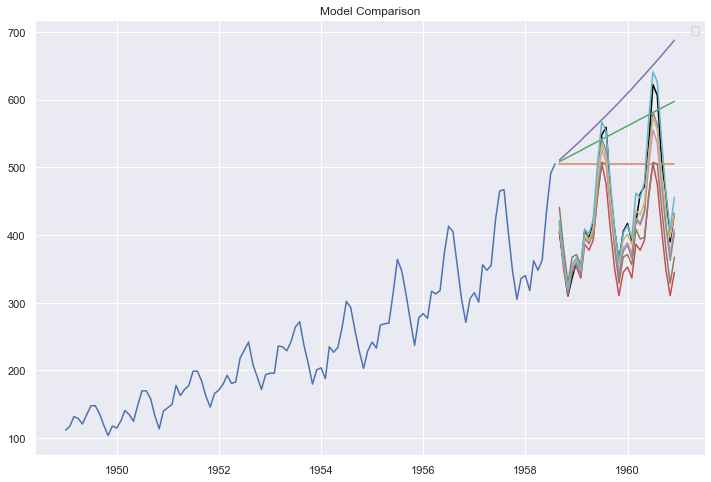

INFO:pytsal.forecasting:Tuning completed



 ###### TUNING SUMMARY #####

   model_name                                 args       score    aicc
8  HoltWinter  {'trend': 'mul', 'seasonal': 'mul'}   13.060240  559.88
7  HoltWinter  {'trend': 'mul', 'seasonal': 'add'}   15.610859  607.52
6  HoltWinter  {'trend': 'add', 'seasonal': 'mul'}   20.689976  561.14
5  HoltWinter  {'trend': 'add', 'seasonal': 'add'}   23.617041  608.54
4  HoltWinter   {'trend': None, 'seasonal': 'mul'}   42.557084  509.11
2  HoltWinter   {'trend': None, 'seasonal': 'add'}   52.698995  635.81
0  HoltWinter    {'trend': None, 'seasonal': None}   91.816338  766.94
1  HoltWinter   {'trend': 'add', 'seasonal': None}  120.820595  769.55
3  HoltWinter   {'trend': 'mul', 'seasonal': None}  156.872776  769.87

Best model: {'trend': 'mul', 'seasonal': 'mul'} with score: 13.060240160093155
--- Model Summary ---
{'trend': 'mul', 'seasonal': 'mul'}


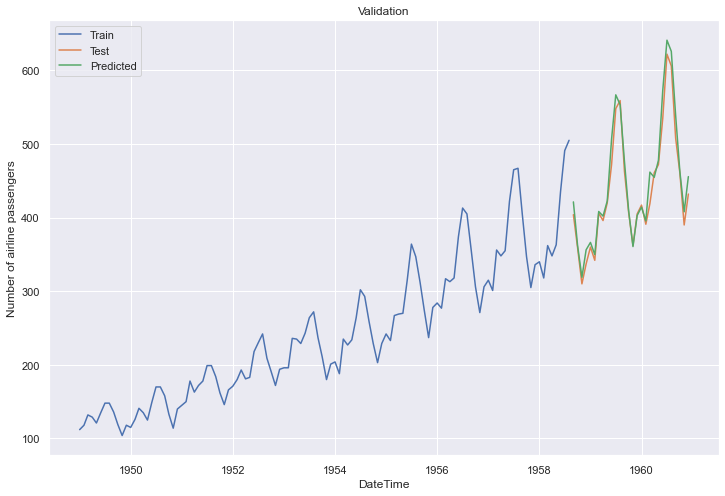

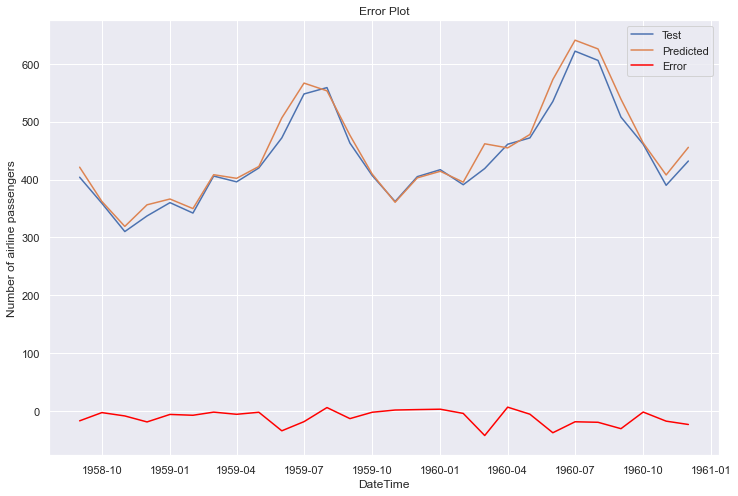

INFO:pytsal.forecasting:Experiment ended @ 2022-07-27 23:42:42.066536


MAE      13.060240
MAPE      0.029047
RMSE     17.581375
AIC     552.826625
BIC     596.884068
AICC    559.878171
Name: Model metrics, dtype: float64


In [36]:
from pytsal.forecasting import *

model = setup(ts, 'holtwinter', eda=True, validation=True, find_best_model=True, plot_model_comparison=True)

In [37]:
trained_model = finalize(ts, model)

INFO:pytsal.forecasting:Finalizing model (Training on complete data) ... 


                           ExponentialSmoothing Model Results                           
Dep. Variable:     Number of airline passengers   No. Observations:                  144
Model:                     ExponentialSmoothing   SSE                          15805.297
Optimized:                                 True   AIC                            708.553
Trend:                           Multiplicative   BIC                            756.070
Seasonal:                        Multiplicative   AICC                           714.025
Seasonal Periods:                            12   Date:                 Wed, 27 Jul 2022
Box-Cox:                                  False   Time:                         23:45:01
Box-Cox Coeff.:                            None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.291